# Sentiment Analysis using Convolution Neural Network  

**A Convolutional Neural Network (CNN)** is a type of deep learning model designed to process data with a grid-like structure, such as images. It works by automatically learning hierarchical patterns from input data using layers like convolution, pooling, and fully connected layers. The convolution layer extracts features like edges or shapes by applying filters, pooling reduces dimensionality to make the computation efficient, and fully connected layers combine these features for final predictions. CNNs are widely used in tasks like image recognition, object detection, and even natural language processing due to their ability to capture spatial and local dependencies effectively.

## Import the Requirments

In [1]:
!pip install datasets
!pip install torchtext==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.4 MB/s eta 0:00:00
   ━━━━

In [2]:
import collections

import torch
import torch.nn as nn
import torch.optim as optim

import tqdm
import datasets
import torchtext

import numpy as np
import matplotlib.pyplot as plt

In [3]:
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Load the dataset

In [4]:
train_data, test_data = datasets.load_dataset('imdb', split=['train', 'test'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
train_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

## **Tokenize** the dataset

use the `basic_english` tokenization from the **torchtext**

In [6]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [7]:
tokenizer("Hello World!")

['hello', 'world', '!']

In [8]:
def tokenize(example, tokenizer, max_length=200):
    return {'tokens': tokenizer(example['text'])[:max_length]}

In [9]:
max_length = 256

train_data = train_data.map(tokenize, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
test_data = test_data.map(tokenize, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [10]:
train_data.features, test_data.features

({'text': Value(dtype='string', id=None),
  'label': ClassLabel(names=['neg', 'pos'], id=None),
  'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)},
 {'text': Value(dtype='string', id=None),
  'label': ClassLabel(names=['neg', 'pos'], id=None),
  'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)})

## Create the vocabulary

In [11]:
min_freq = 5

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data['tokens'],
    min_freq=min_freq,
    specials=['<unk>', '<pad>'],
)

In [12]:
unk_index = vocab['<unk>']
pad_index = vocab['<pad>']

print(f'Unknown token index: {unk_index}')
print(f'Padding token index: {pad_index}')

Unknown token index: 0
Padding token index: 1


In [13]:
vocab.set_default_index(unk_index)

## Numericalize the Vocabulary

In [14]:
def numericalize(example, vocab):
    return {'ids': vocab.lookup_indices(example['tokens'])}

In [15]:
train_data = train_data.map(numericalize, fn_kwargs={'vocab': vocab})
test_data = test_data.map(numericalize, fn_kwargs={'vocab': vocab})

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

## Create the validation

In [16]:
train_val_data = train_data.train_test_split(test_size=0.25)
train_data, val_data = train_val_data['train'], train_val_data['test']

In [17]:
len(train_data), len(val_data), len(test_data)

(18750, 6250, 25000)

In [18]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

## Export data to torch.tensor

In [19]:
train_data = train_data.with_format('torch', columns=['ids', 'label'])
val_data = val_data.with_format('torch', columns=['ids', 'label'])
test_data = test_data.with_format('torch', columns=['ids', 'label'])

## Create the data Loaders

In [20]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [x['ids'] for x in batch]
        batch_labels = [x['label'] for x in batch]
        batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
        batch_labels = torch.stack(batch_labels)
        return {'ids': batch_ids, 'label': batch_labels}
    return collate_fn

In [21]:
def get_data_loader(dataset, batch_size, shuffle=False):
    collate_fn = get_collate_fn(pad_index)

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn,
    )

In [22]:
batch_size = 512

train_loader = get_data_loader(train_data, batch_size, shuffle=True)
val_loader = get_data_loader(val_data, batch_size)
test_loader = get_data_loader(test_data, batch_size)

## Build the network

In [23]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes,
                 output_dim, dropout, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.conv = nn.ModuleList(
            [
                nn.Conv1d(embedding_dim, n_filters, filter_size) for filter_size in filter_sizes
            ]
        )
        self.fc = nn.Linear(n_filters*len(filter_sizes), output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, idx):
        embedded = self.embedding(idx)  # B, seq_len, embd_dim
        embedded = embedded.permute(0, 2, 1)  # B, embd_dim, seq_len
        conved = [torch.relu(conv(embedded)) for conv in self.conv]  # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]
        pooled = [torch.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]  # pooled_n = [batch size, n filters]
        cat = self.dropout(torch.cat(pooled, dim=1))  # cat = [batch size, n filters * len(filter_sizes)]
        return self.fc(cat)  # prediction = [batch size, output dim]

In [24]:
vocab_size = len(vocab)
dropout = 0.25
embedding_dim = 300
n_filters = 100
filter_sizes = [3, 5, 7]
output_dim = len(train_data.unique('label'))

model = CNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    n_filters=n_filters,
    filter_sizes=filter_sizes,
    output_dim=output_dim,
    dropout=dropout,
    pad_index=pad_index
)

Flattening the indices:   0%|          | 0/18750 [00:00<?, ? examples/s]

In [25]:
def coutn_param(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {coutn_param(model):,} trainable parameters')

The model has 7,920,002 trainable parameters


In [26]:
def initialize_weights_(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        nn.init.zeros_(m.bias)

In [27]:
model.apply(initialize_weights_)

CNN(
  (embedding): Embedding(24897, 300, padding_idx=1)
  (conv): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(7,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [28]:
vectors = torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [06:50, 5.31MB/s]                            
100%|█████████▉| 2196016/2196017 [04:59<00:00, 7341.50it/s]


In [29]:
pretrained_weights = vectors.get_vecs_by_tokens(vocab.get_itos())

In [31]:
model.embedding.weight.data = pretrained_weights

In [32]:
optimizer = optim.AdamW(model.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:
model = model.to(device)
criterion = criterion.to(device)

In [35]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    correct = prediction.argmax(dim=1).eq(label).sum()
    return correct / batch_size

In [36]:
def train(model, criterion, optimizer, device, train_loader):
    model.train()
    epoch_loss = []
    epoch_acc = []
    for batch in tqdm.tqdm(train_loader, desc='Training...'):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)

        prediction = model(ids)
        loss = criterion(prediction, label)
        acc = get_accuracy(prediction, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())

    return np.mean(epoch_loss), np.mean(epoch_acc)

In [37]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [38]:
n_epochs = 10
best_valid_loss = float('inf')
metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, device, train_loader)
    valid_loss, valid_acc = evaluate(val_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.92it/s]


epoch: 0
train_loss: 0.885, train_acc: 0.669
valid_loss: 0.377, valid_acc: 0.832


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 17.25it/s]


epoch: 1
train_loss: 0.280, train_acc: 0.884
valid_loss: 0.309, valid_acc: 0.865


evaluating...: 100%|██████████| 13/13 [00:01<00:00, 11.66it/s]


epoch: 2
train_loss: 0.166, train_acc: 0.943
valid_loss: 0.297, valid_acc: 0.872


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.99it/s]


epoch: 3
train_loss: 0.092, train_acc: 0.977
valid_loss: 0.296, valid_acc: 0.878


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 14.39it/s]


epoch: 4
train_loss: 0.051, train_acc: 0.992
valid_loss: 0.308, valid_acc: 0.878


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 17.03it/s]


epoch: 5
train_loss: 0.028, train_acc: 0.998
valid_loss: 0.320, valid_acc: 0.878


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.37it/s]


epoch: 6
train_loss: 0.017, train_acc: 0.999
valid_loss: 0.337, valid_acc: 0.877


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 17.06it/s]


epoch: 7
train_loss: 0.011, train_acc: 1.000
valid_loss: 0.351, valid_acc: 0.878


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 17.14it/s]


epoch: 8
train_loss: 0.008, train_acc: 1.000
valid_loss: 0.363, valid_acc: 0.876


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 16.10it/s]

epoch: 9
train_loss: 0.006, train_acc: 1.000
valid_loss: 0.377, valid_acc: 0.879


In [40]:
plt.style.use('ggplot')

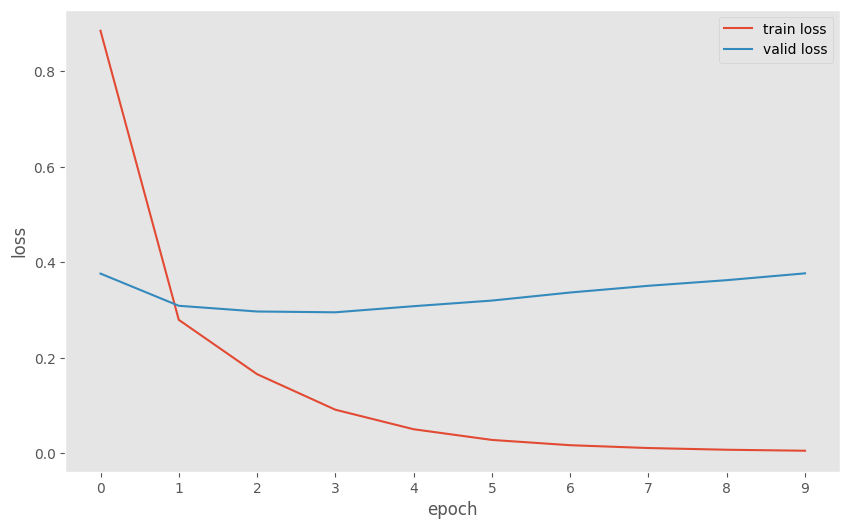

In [41]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

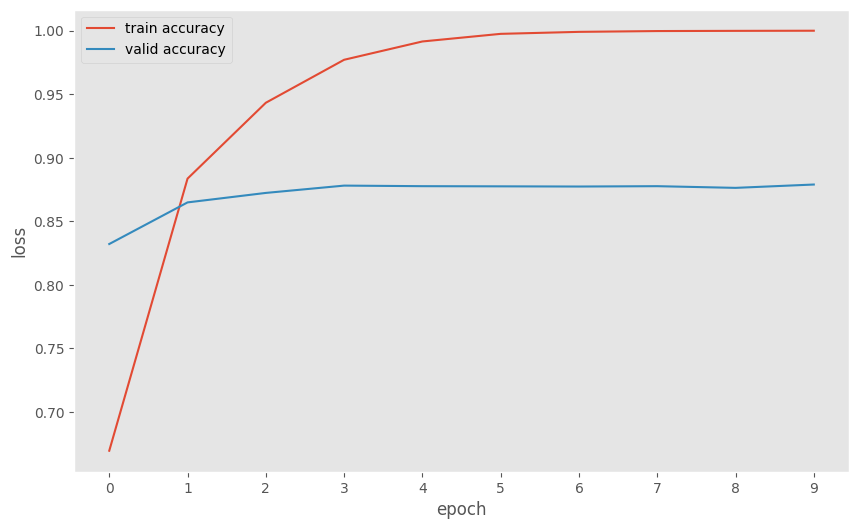

In [42]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [44]:
model.load_state_dict(torch.load("cnn.pt"))

test_loss, test_acc = evaluate(test_loader, model, criterion, device)

evaluating...: 100%|██████████| 49/49 [00:03<00:00, 15.86it/s]


In [45]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.310, test_acc: 0.868


In [46]:
def predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    if len(ids) < min_length:
        ids += [pad_index] * (min_length - len(ids))
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [47]:
text = "This film is terrible!"
min_length = max(filter_sizes)

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(0, 0.9886506795883179)

In [48]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.9561065435409546)

In [49]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(0, 0.8642379641532898)

In [50]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.7127465605735779)